In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [ ]:
batch_size = 16
learning_rate = 0.001#5e-2
num_epochs = 10
use_gpu = False
if torch.cuda.is_available():
  use_gpu = True
  print("using cuda")

using cuda


In [ ]:
import os.path as osp
import torchvision.transforms as T
from PIL import Image

class SegSTRONGC(data.Dataset):
    def __init__(self, root_folder: str, set_indices: list, subset_indices: list, split: str = 'train', domains: list = ['regular'], image_transforms = None, gt_transforms = None):
        '''
            reference dataset loading for SegSTRONGC
            root_folder: the root_folder of the SegSTRONGC dataset
            set_indices: is the indices for sets to be used
            subset_indices: is the indices for the subsets to be used
            split: 'train', 'val' or 'test'
            domain: the image domains to be loaded.
            image_transforms: any transforms to perform, can add augmentations here.
            gt_transforms: list of bool. Indicates whether image_transforms should also be appleid to gt.
        '''
        self.split = split
        self.root_folder = root_folder
        self.set_indices = set_indices
        self.subset_indices = subset_indices
        self.domains = domains
        self.image_transforms = image_transforms
        self.gt_transforms = gt_transforms

        self.image_paths = []
        self.gt_paths = []

        for set_idx, s in enumerate(self.set_indices):
            for ss in self.subset_indices[set_idx]:
                set_folder = osp.join(self.root_folder, self.split + '/' + str(s) + '/' + str(ss))
                gt_folder = osp.join(set_folder, 'ground_truth')

                for d in self.domains:
                    image_folder = osp.join(set_folder, d)
                    for i in range(300):
                        image_name = str(i) + ".jpg"
                        gt_name = str(i) + ".png"
                        self.image_paths.append(osp.join(image_folder, 'left/' + image_name))
                        self.gt_paths.append(osp.join(gt_folder, 'left/' + gt_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        image = np.array(Image.open(self.image_paths[idx])).astype(np.float32) / 255
        gt = (np.array(Image.open(self.gt_paths[idx])) / 255).astype(np.int64)
        # Apply transformation to image and ground truth
        if self.image_transforms is not None and self.gt_transforms is not None:
            image = self.image_transforms(image)
            gt = self.gt_transforms(gt)
        else:
            image = T.ToTensor()(image)
            gt = T.ToTensor()(gt)

        return image, gt

In [ ]:

def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )


def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )

class unet(nn.Module):
  def __init__(self, useBN=False):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1   = add_conv_stage(3, 32, useBN=useBN)
    self.conv2   = add_conv_stage(32, 64, useBN=useBN)
    self.conv3   = add_conv_stage(64, 128, useBN=useBN)
    self.conv4   = add_conv_stage(128, 256, useBN=useBN)
    self.conv5   = add_conv_stage(256, 512, useBN=useBN)
    # Upgrade stages
    self.conv4m = add_conv_stage(512, 256, useBN=useBN)
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample54 = upsample(512, 256)
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)

    self.conv_final = nn.Conv2d(32, 1,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    conv1_out = self.conv1(x)
    x = self.max_pool(conv1_out)
    conv2_out = self.conv2(x)
    x = self.max_pool(conv2_out)
    conv3_out = self.conv3(x)
    x = self.max_pool(conv3_out)
    conv4_out = self.conv4(x)
    x = self.max_pool(conv4_out)
    conv5_out = self.conv5(x)
    # Up
    upsample54_out = self.upsample54(conv5_out)
    x = torch.cat((upsample54_out, conv4_out), 1)
    x = self.conv4m(x)
    x = self.upsample43(x)
    x = torch.cat((x, conv3_out), 1)
    conv3m_out = self.conv3m(x)
    x = self.upsample32(conv3m_out)
    x = torch.cat((x, conv2_out), 1)
    x = self.conv2m(x)
    x = self.upsample21(x)
    x = torch.cat((x, conv1_out), 1)
    x = self.conv1m(x)
    x = self.conv_final(x)
    x = self.sigmoid(x)
    return x


In [ ]:
def trainning(model, trainning_dataloader, validation_dataloader, num_epochs, criterion, optimizer, filename):
    if use_gpu:
      model.cuda()
    lr_changed = False
    trainning_losses = []
    validation_losses = []
    total_training_loss = 0
    total_val_loss = 0
    total_training_iteration = 0
    total_val_iteration = 0
    for epoch in range(num_epochs):
        i = 0
        model.train()
        for data in trainning_dataloader:
          img,y = data
          if use_gpu:
            img = img.cuda()
            y = y.cuda()
          out = model(img)
          model.zero_grad()
          loss = criterion(out, y)
          total_training_loss += loss.item()
          loss.backward()
          optimizer.step()
          i = i+1
          total_training_iteration += 1
          if total_training_iteration % 100 == 99:
            trainning_losses.append(total_training_loss / total_training_iteration)
        if epoch % 5 == 4:
            print("learning_rate decayed")
            for param_group in optimizer.param_groups:
              param_group['lr'] *= 0.1
        model.eval()
        for data in validation_dataloader:
          img,y = data
          if use_gpu:
            img = img.cuda()
            y = y.cuda()
          out = model(img)
          model.zero_grad()
          loss = criterion(out, y)
          total_val_loss += loss.item()
          total_val_iteration += 1
          if total_val_iteration % 100 == 99:
            validation_losses.append(total_val_loss / total_val_iteration)
        print("epoch:",epoch,"training_loss:",total_training_loss / total_training_iteration, "validation_loss:",total_val_loss / total_val_iteration)
        torch.save(model.state_dict(), filename)
    plt.plot(trainning_losses, linewidth=3,label='training loss')
    plt.plot(validation_losses,linewidth=3, label='validation loss')
    plt.xlabel('iteration', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('loss.'+str(filename)+'.png',dpi=300)
    plt.show()

In [ ]:
def DICE(model, test_dataloader, smooth=1e-10):
    dice = []
    model.eval()
    for data in test_dataloader:
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        predict = model(img) > 0.5
        num = 2 * (predict * target).sum()
        denum = predict.sum() + target.sum()
        dice.append(((num + smooth) / (denum + smooth)).item())
    m_dice = np.mean(dice)
    return m_dice


def DICELoss(score,target):
    smooth=1e-5
    target=target.float()
    num = 2 * (score * target).sum(dim=(1,2,3))
    denum=score.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice_loss=1-((num + smooth) / (denum + smooth))
    return dice_loss.mean()

In [ ]:
root_folder = "./SegSTRONGC_MLDL"
size = (272, 480)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_set_indices = [3, 4, 5, 7, 8]
train_subset_indices = [[0, 2], [0, 1, 2], [0, 2], [0, 1], [1, 2]]

train_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])
train_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
])
segmentation_trainning_dataset = SegSTRONGC(
    root_folder = root_folder,
    set_indices = train_set_indices,
    subset_indices = train_subset_indices,
    split = 'train',
    domains = ['regular'],
    image_transforms = train_image_transforms,
    gt_transforms = train_gt_transforms)
segmentation_trainning_dataloader = DataLoader(segmentation_trainning_dataset, batch_size=batch_size, shuffle=True)

val_set_indices = [1]
val_subset_indices = [[0]]

val_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])
val_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
])
segmentation_validation_dataset = SegSTRONGC(
    root_folder = root_folder,
    set_indices = val_set_indices,
    subset_indices = val_subset_indices,
    split = 'val',
    domains = ['regular'],
    image_transforms = val_image_transforms,
    gt_transforms = val_gt_transforms)

segmentation_validation_dataloader = DataLoader(segmentation_validation_dataset, batch_size=1, shuffle=False)

test_set_indices = [9]
test_subset_indices = [[0]]

test_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])
test_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
])
segmentation_test_dataset = SegSTRONGC(
    root_folder = root_folder,
    set_indices = test_set_indices,
    subset_indices = test_subset_indices,
    split = 'test',
    domains = ['regular'],
    image_transforms = test_image_transforms,
    gt_transforms = test_gt_transforms)

segmentation_test_dataloader = DataLoader(segmentation_test_dataset, batch_size=1, shuffle=False)

segmentation_test_dataset_blood = SegSTRONGC(
    root_folder = root_folder,
    set_indices = test_set_indices,
    subset_indices = test_subset_indices,
    split = 'test',
    domains = ['blood'],
    image_transforms = test_image_transforms,
    gt_transforms = test_gt_transforms)

segmentation_test_dataloader_blood = DataLoader(segmentation_test_dataset_blood, batch_size=1, shuffle=False)


In [31]:
def show_demo(model, test_dataset_loader, num=10):
    model.eval()
    count = 0
    for demo in test_dataset_loader:
        demo_input, demo_target = demo
        if use_gpu:
           demo_input = demo_input.cuda()
        demo_output = model(demo_input)
        for i in range(demo_input.shape[0]):
            plt.subplot(1, 3, 1)
            plt.imshow(demo_input[i].permute(1,2,0).detach().cpu().numpy())
            plt.axis("off")
            plt.subplot(1, 3, 2)
            plt.imshow(demo_output[i].detach().cpu().numpy().squeeze()*255)
            plt.axis("off")
            plt.subplot(1, 3, 3)
            plt.imshow(demo_target[i].detach().numpy().squeeze())
            plt.axis("off")
            plt.show()
        if count >= num:
          break
        count += 1

epoch: 0 training_loss: 0.21115709808857544 validation_loss: 0.1307681401570638
epoch: 1 training_loss: 0.13059394209137284 validation_loss: 0.10501545468966166
epoch: 2 training_loss: 0.09905456818772207 validation_loss: 0.0900364711549547
epoch: 3 training_loss: 0.08242147655680704 validation_loss: 0.08198156982660293
learning_rate decayed
epoch: 4 training_loss: 0.07143634271578513 validation_loss: 0.07711670958995819
epoch: 5 training_loss: 0.06350943328281819 validation_loss: 0.07613671584261789
epoch: 6 training_loss: 0.05768681899114178 validation_loss: 0.07531344972905658
epoch: 7 training_loss: 0.053246393304876086 validation_loss: 0.07500165830055873
epoch: 8 training_loss: 0.04970727264441218 validation_loss: 0.07490866742752217
learning_rate decayed
epoch: 9 training_loss: 0.0467845708221773 validation_loss: 0.07515030308564503


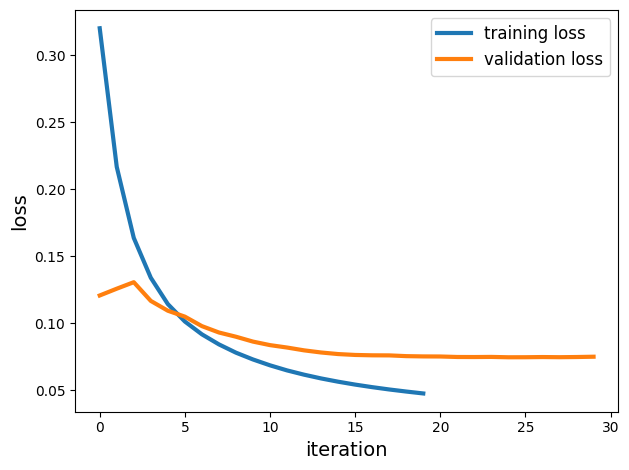

CPU times: user 38min 9s, sys: 9.52 s, total: 38min 19s
Wall time: 10min 4s


In [32]:
%%time
segmentation_model = unet(useBN=True)
dice_criterion = DICELoss
segmentation_optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainning(segmentation_model, segmentation_trainning_dataloader, segmentation_validation_dataloader,  num_epochs, dice_criterion, segmentation_optimizer, "final_vanilla_model.pth")

/tmp/ipykernel_6719/4223396084.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model.load_state_dict(torch.load("final_vanilla_model.pth"))
Clipping input d

0.9294251863161723


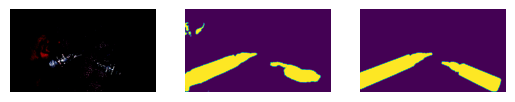

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


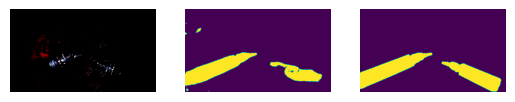

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


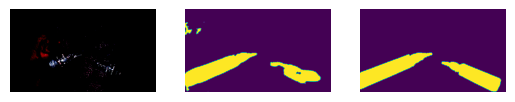

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


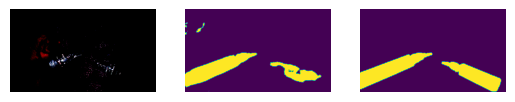

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


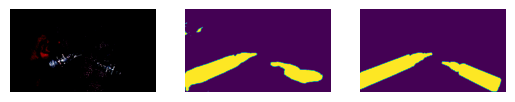

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


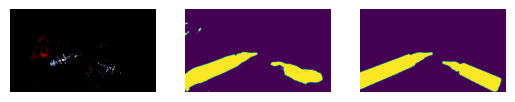

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


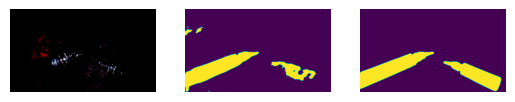

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


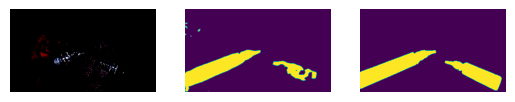

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


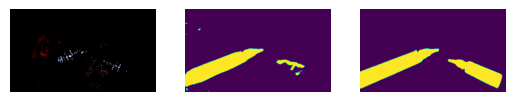

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


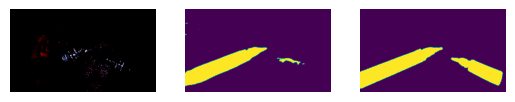

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


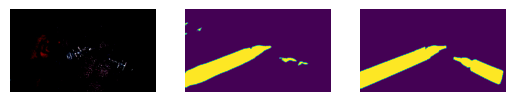

In [33]:
segmentation_model.load_state_dict(torch.load("final_vanilla_model.pth"))
print(DICE(segmentation_model, segmentation_test_dataloader))
show_demo(segmentation_model, segmentation_test_dataloader)

/tmp/ipykernel_6719/1671474167.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model.load_state_dict(torch.load("final_vanilla_model.pth"))
Clipping input d

0.4472108992934227


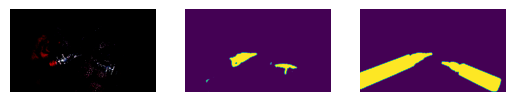

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


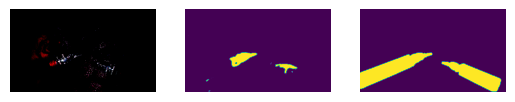

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


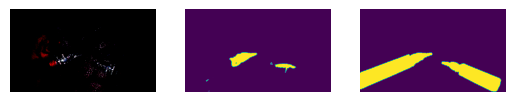

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


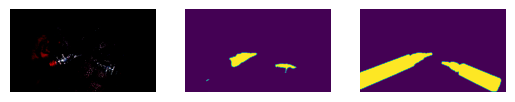

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


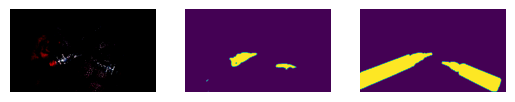

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


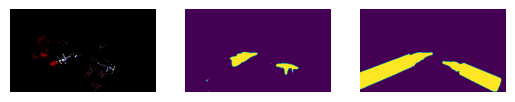

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


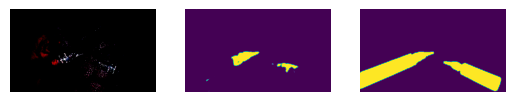

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


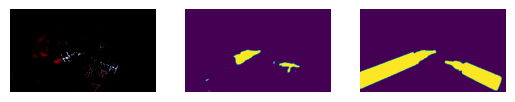

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


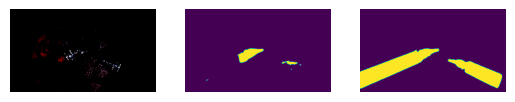

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


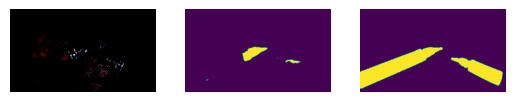

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


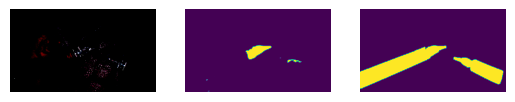

In [34]:
segmentation_model.load_state_dict(torch.load("final_vanilla_model.pth"))
print(DICE(segmentation_model, segmentation_test_dataloader_blood))
show_demo(segmentation_model, segmentation_test_dataloader_blood)

### Data augmentation for better trainning with blood situation.

In [ ]:
from torchvision.transforms import v2
train_image_transforms_augmented = transforms.Compose([
    transforms.ToTensor(),                              # Convert the image to a PyTorch tensor
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),                      # Resize the image to the desired size
    transforms.Normalize(mean=mean, std=std),            # Normalize the image with mean and std
    transforms.RandomApply([
    #transforms.GaussianBlur(kernel_size=3,sigma=(0.01,0.05)),        # Gaussian blur
    transforms.ColorJitter(brightness=0.05, contrast=0.1, saturation=0.05, hue=0.), #color jitter
    v2.GaussianNoise(mean=0,sigma=0.06),                       # Gaussian noise
    ],p=0.05)
])

train_gt_transforms_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    
])
segmentation_trainning_dataset_augmented = SegSTRONGC(
    root_folder = root_folder,
    set_indices = train_set_indices,
    subset_indices = train_subset_indices,
    split = 'train',
    domains = ['regular'],
    image_transforms = train_image_transforms_augmented,
    gt_transforms = train_gt_transforms_augmented)
segmentation_trainning_dataloader_augmented = DataLoader(segmentation_trainning_dataset_augmented, batch_size=batch_size, shuffle=True)

epoch: 0 training_loss: 0.23683187138775122 validation_loss: 0.24343333343664805
epoch: 1 training_loss: 0.16533243733543704 validation_loss: 0.166562783519427
epoch: 2 training_loss: 0.1388904138283741 validation_loss: 0.13616811136404675
epoch: 3 training_loss: 0.1219366232275171 validation_loss: 0.12312016740441323
learning_rate decayed
epoch: 4 training_loss: 0.11077501910968103 validation_loss: 0.11514818346500397
epoch: 5 training_loss: 0.10143374527794055 validation_loss: 0.10644858605331844
epoch: 6 training_loss: 0.09383516008480407 validation_loss: 0.10178702504861922
epoch: 7 training_loss: 0.08837778897560089 validation_loss: 0.09773210436105728
epoch: 8 training_loss: 0.08395169469589389 validation_loss: 0.0944703123525337
learning_rate decayed
epoch: 9 training_loss: 0.08032421505681558 validation_loss: 0.09305130596955617
epoch: 10 training_loss: 0.0769310544179912 validation_loss: 0.09135812716050581
epoch: 11 training_loss: 0.07387073809242 validation_loss: 0.089671677

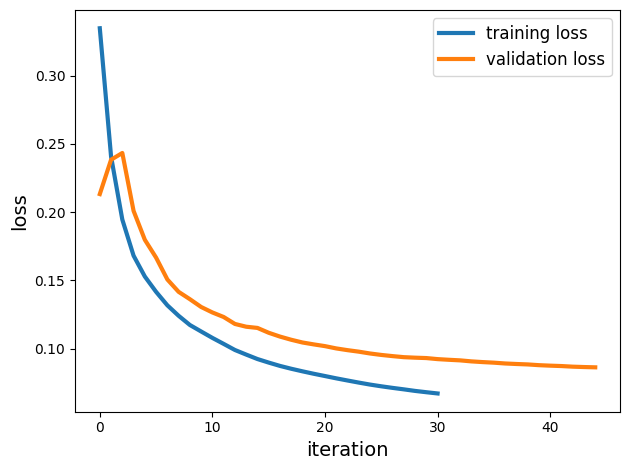

CPU times: user 58min 4s, sys: 28.7 s, total: 58min 32s
Wall time: 15min 9s


In [38]:
%%time
torch.cuda.empty_cache() #free gpu memory
segmentation_model_augmented = unet(useBN=True)
dice_criterion = DICELoss
num_epochs=15
segmentation_optimizer_augmented = torch.optim.Adam(segmentation_model_augmented.parameters(), lr=learning_rate, weight_decay=1e-4)
trainning(segmentation_model_augmented, segmentation_trainning_dataloader_augmented, segmentation_validation_dataloader,  num_epochs, dice_criterion, segmentation_optimizer_augmented, "final_augmented_model.pth")

/tmp/ipykernel_6719/3140738636.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("final_augmented_model.pth"))
Clip

0.9387463935216268


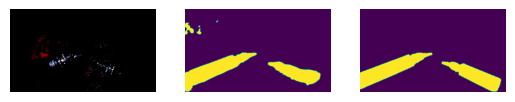

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


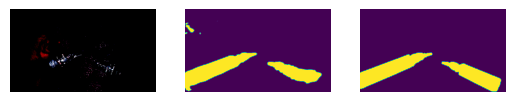

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


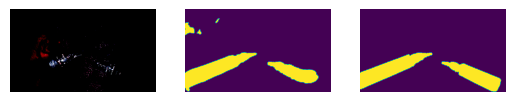

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


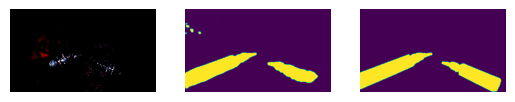

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


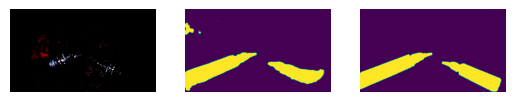

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


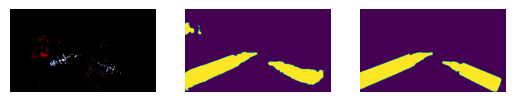

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


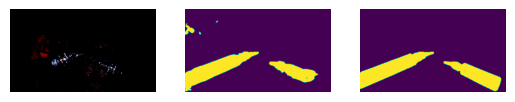

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


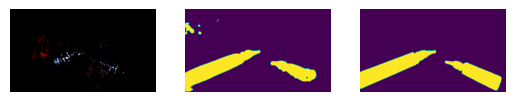

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


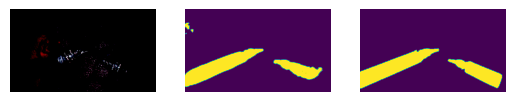

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


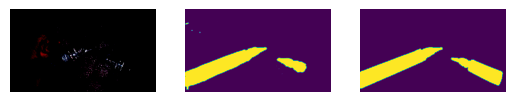

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


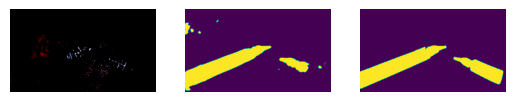

In [39]:
segmentation_model_augmented.load_state_dict(torch.load("final_augmented_model.pth"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader))
show_demo(segmentation_model_augmented, segmentation_test_dataloader)

/tmp/ipykernel_6719/3275041932.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("final_augmented_model.pth"))
Clip

0.5332234869897365


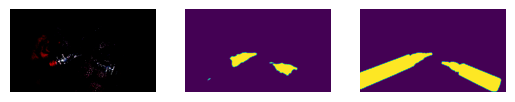

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


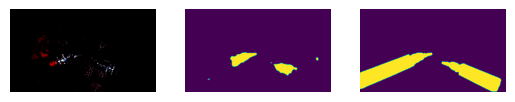

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


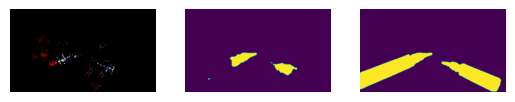

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


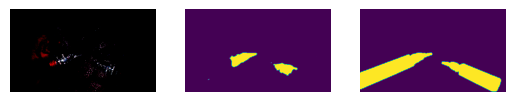

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


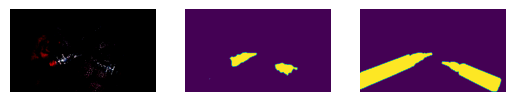

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


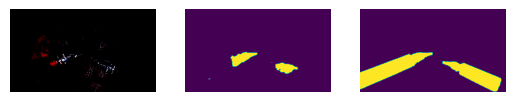

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


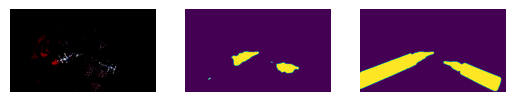

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


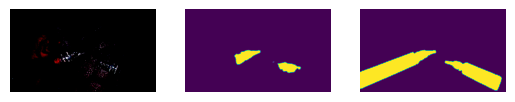

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


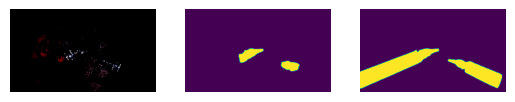

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


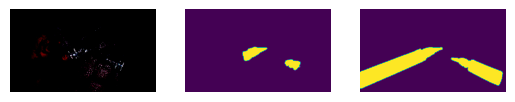

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


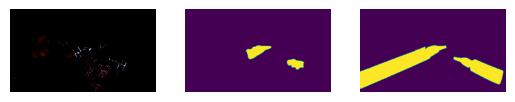

In [40]:
segmentation_model_augmented.load_state_dict(torch.load("final_augmented_model.pth"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader_blood))
show_demo(segmentation_model_augmented, segmentation_test_dataloader_blood)